In [2]:
# import statements
from Tools.toolbox import *
from Tools.functions import *
import csv
from scipy.stats import ks_2samp
import pandas as pd

In [3]:
dates_ebola = []
countries_ebola = []
with open('data/ebola_sorted.csv', 'r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip the header row
    for row in reader:
        countries_ebola.append(row[0])
        dates_ebola.append(row[4])

data = {
    'Country': countries_ebola,
    'Date Onset Inferred': dates_ebola
}

df = pd.DataFrame(data)
df = df[df['Date Onset Inferred'] != 'NA']
countries = df.groupby('Country')
df_guinea = countries.get_group('Guinea')
dates_guinea = [date for date in df_guinea['Date Onset Inferred']]
df_liberia = countries.get_group('Liberia')
dates_liberia = [date for date in df_liberia['Date Onset Inferred']]
df_sierra = countries.get_group('Sierra Leone')
dates_sierra = [date for date in df_sierra['Date Onset Inferred']]
def sort_dates(dates):
    def date_key(date_string):
        return datetime.strptime(date_string, '%d/%m/%Y')
    return sorted(dates, key=date_key)
dates_all = sort_dates(df['Date Onset Inferred'])

In [4]:
date_nums_guinea = [convert_date_to_numberB(date, dates_guinea[0]) for date in dates_guinea]
date_nums_liberia = [convert_date_to_numberB(date, dates_liberia[0]) for date in dates_liberia]
date_nums_sierra = [convert_date_to_numberB(date, dates_sierra[0]) for date in dates_sierra]
date_nums_all = [convert_date_to_numberB(date, dates_all[0]) for date in dates_all]

In [5]:
observed_guinea = distribute(date_nums_guinea)
observed_liberia = distribute(date_nums_liberia)
observed_sierra = distribute(date_nums_sierra)
observed_all = distribute(date_nums_all)

In [6]:
event_times = observed_all

## Simulation from 150 days

In [8]:
n = binary_search(event_times, 150)
paras = [0.72306694, 0.72543727, 0.11557651]
bnds = ((0.01, 1), (0.01, 1), (0.01, 10))
intensity = lambda t, paras: intensity_constructor(t, paras, event_times, ExpKernel, ConstBase, depth=30)
result = MLE_de(intensity, event_times[:n], model="constexp", bounds=bnds, maxiter=10)
optimized_params_150 = result.x
print(optimized_params_150)

[0.25752509 0.30160191 0.34684469]


In [9]:
paras = optimized_params_150
intensity = lambda t, event_times: intensity_constructor(t, paras, event_times, ExpKernel, ConstBase, depth=30)
n = binary_search(event_times, 150)
samples_thinning150 = []
samples_branching150 = []
for _ in range(100):
    samples_thinning150.append(simulate_hawkes_process(intensity, event_times[:n], 180))
    samples_branching150.append(simulate_cluster_structure(ExpKernel(*paras[:2]), ConstBase(paras[-1]), event_times[:n], 180))

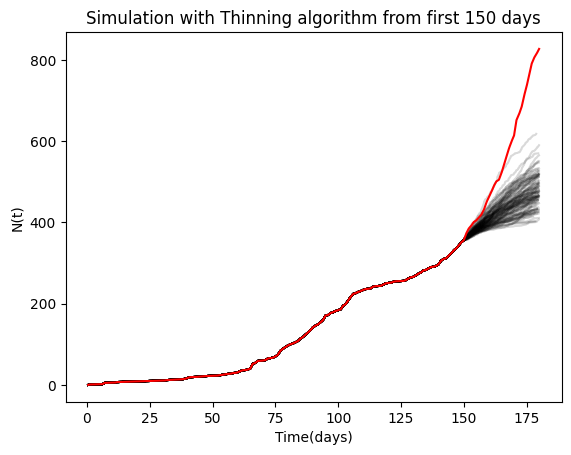

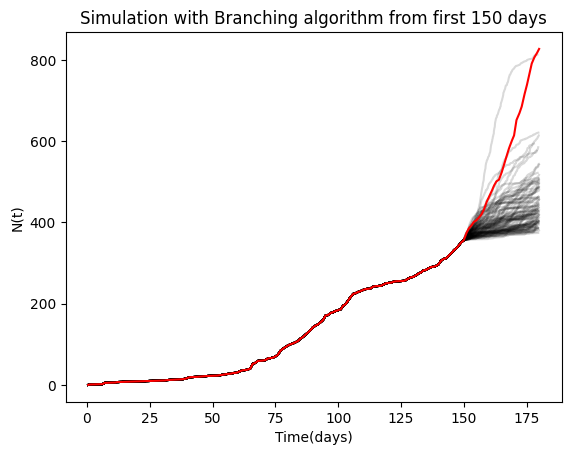

In [10]:
n = binary_search(event_times, 180)
for sample in samples_thinning150:
    plt.plot(sample, range(len(sample)), color="k", alpha=0.15)
plt.plot(event_times[:n], range(n), color='r')
plt.title("Simulation with Thinning algorithm from first 150 days")
plt.xlabel("Time(days)")
plt.ylabel("N(t)")
plt.show()

for sample in samples_branching150:
    plt.plot(sample, range(len(sample)), color="k", alpha=0.15)
plt.plot(event_times[:n], range(n), color='r')
plt.xlabel("Time(days)")
plt.ylabel("N(t)")
plt.title("Simulation with Branching algorithm from first 150 days")
plt.show()

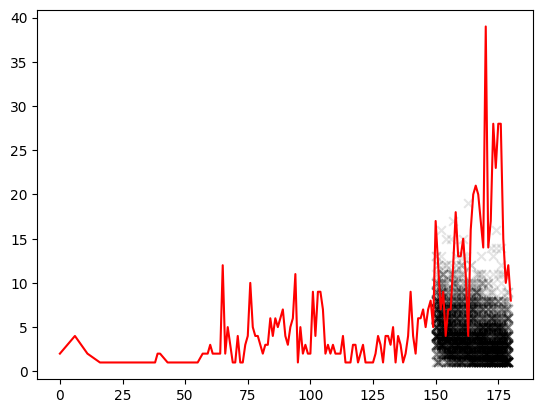

In [11]:
n = binary_search(date_nums_all, 180)
times = date_nums_all[:n]
count = Counter(times)
keys = count.keys()
values = [count[key] for key in keys]
plt.plot(keys, values, color = 'r')

for sample in samples_thinning150:
    n = binary_search(sample, 150)
    times = np.floor(sample[n:])
    count = Counter(times)
    keys = count.keys()
    values = [count[key] for key in keys]
    plt.scatter(keys, values, color='k', marker='x', s=40, alpha=0.1)

## Simulation from 300 days

In [13]:
n = binary_search(event_times, 300)
paras = [0.72306694, 0.72543727, 0.11557651]
bnds = ((0.01, 2), (0.01, 2), (0.01, 1))
intensity = lambda t, paras: intensity_constructor(t, paras, event_times, ExpKernel, ConstBase, depth=30)
result = MLE_de(intensity, event_times[:n], model="constexp", bounds=bnds, maxiter=10)
optimized_params_300 = result.x
print(optimized_params_300)

[1.00460486 1.01253209 0.36574301]


In [14]:
paras = optimized_params_300
intensity = lambda t, event_times: intensity_constructor(t, paras, event_times, ExpKernel, ConstBase, depth=30)
n = binary_search(event_times, 300)
samples_thinning300 = []
samples_branching300 = []
for _ in range(100):
    samples_thinning300.append(simulate_hawkes_process(intensity, event_times[:n], 360))
    samples_branching300.append(simulate_cluster_structure(ExpKernel(*paras[:2]), ConstBase(paras[-1]), event_times[:n], 360))

In [19]:
%store samples_thinning300
%store samples_branching300

Stored 'samples_thinning300' (list)
Stored 'samples_branching300' (list)


In [3]:
%store -r samples_branching300

In [20]:
filename = "samples_thinning300.csv"
with open(filename, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(samples_thinning300)

In [4]:
import csv
filename = "B300_all.csv"
with open(filename, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(samples_branching300)

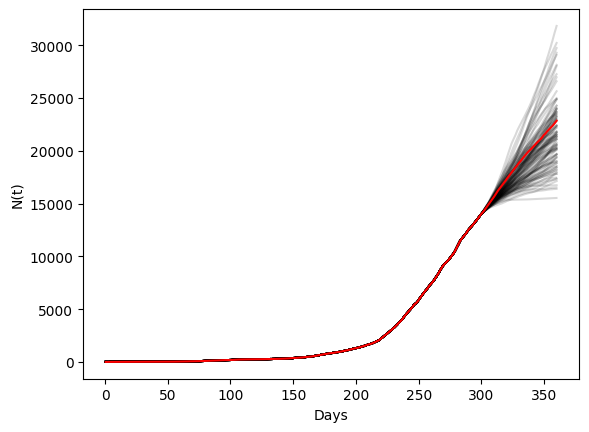

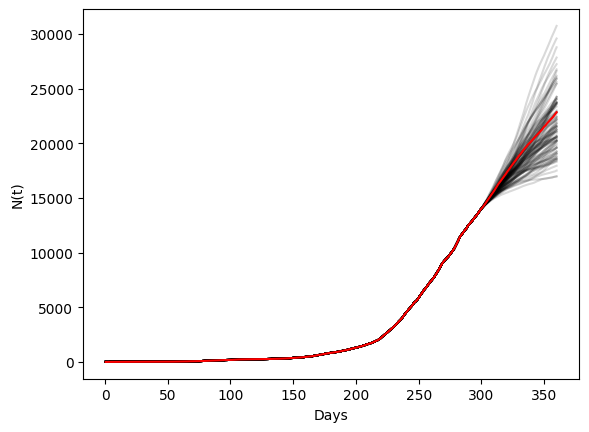

In [17]:
n = binary_search(event_times, 360)
for sample in samples_thinning300:
    plt.plot(sample, range(len(sample)), color="k", alpha=0.15)
plt.plot(event_times[:n], range(n), color='r')
plt.xlabel("Days")
plt.ylabel("N(t)")
plt.show()

for sample in samples_branching300:
    plt.plot(sample, range(len(sample)), color="k", alpha=0.15)
plt.plot(event_times[:n], range(n), color='r')
plt.xlabel("Days")
plt.ylabel("N(t)")
plt.show()

Text(0.5, 0, 'Days')

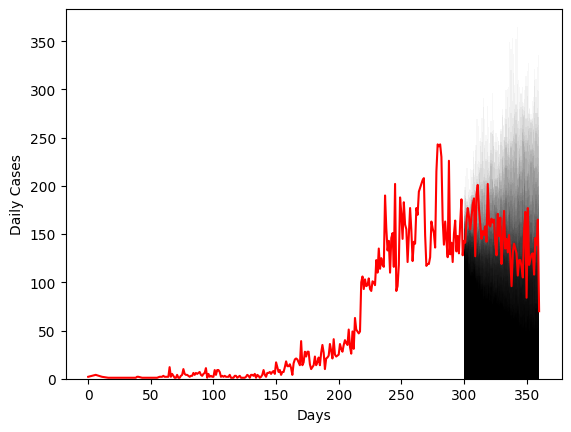

In [35]:
n = binary_search(date_nums_all, 360)
times = date_nums_all[:n]
count = Counter(times)
keys = count.keys()
values = [count[key] for key in keys]
plt.plot(keys, values, color = 'r')

for sample in samples_thinning300:
    n = binary_search(sample, 300)
    plt.hist(sample[n:], color='k', alpha=0.03, bins = 60)

plt.ylabel('Daily Cases')
plt.xlabel('Days')

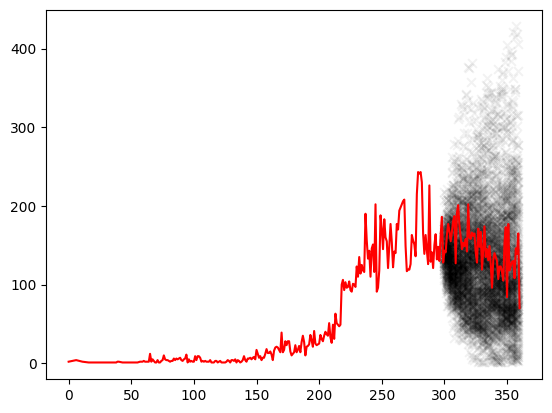

In [18]:
n = binary_search(date_nums_all, 360)
times = date_nums_all[:n]
count = Counter(times)
keys = count.keys()
values = [count[key] for key in keys]
plt.plot(keys, values, color = 'r')

for sample in samples_thinning300:
    n = binary_search(sample, 300)
    times = np.floor(sample[n:])
    count = Counter(times)
    keys = count.keys()
    values = [count[key] for key in keys]
    plt.scatter(keys, values, color='k', marker='x', s=40, alpha=0.05)

## Simulation from 450 days

In [78]:
n = binary_search(event_times, 450)
paras = [0.72306694, 0.72543727, 0.11557651]
bnds = ((0.01, 1), (0.01, 1), (0.01, 1))
intensity = lambda t, paras: intensity_constructor(t, paras, event_times, ExpKernel, ConstBase, depth=30)
result = MLE_de(intensity, event_times, model="constexp", bounds=bnds, maxiter=10)
optimized_params_450 = result.x
print(optimized_params_450)

[0.87498296 0.87950383 0.26892688]


In [13]:
paras = optimized_params_450
intensity = lambda t, event_times: intensity_constructor(t, paras, event_times, ExpKernel, ConstBase, depth=30)
n = binary_search(event_times, 450)
samples_thinning450 = []
samples_branching450 = []
for _ in range(100):
    samples_thinning450.append(simulate_hawkes_process(intensity, event_times[:n], 540))
    samples_branching450.append(simulate_cluster_structure(ExpKernel(*paras[:2]), ConstBase(paras[-1]), event_times[:n], 540))

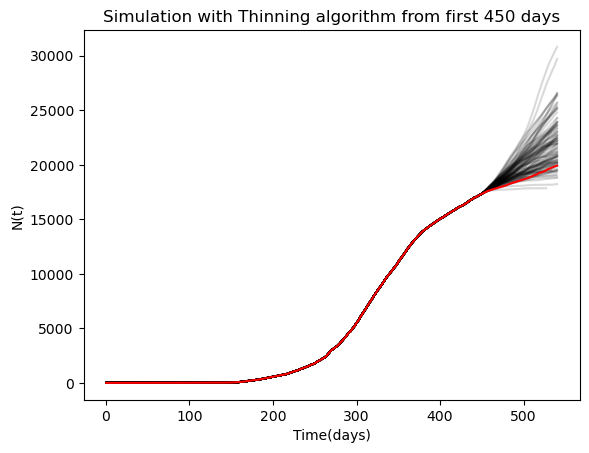

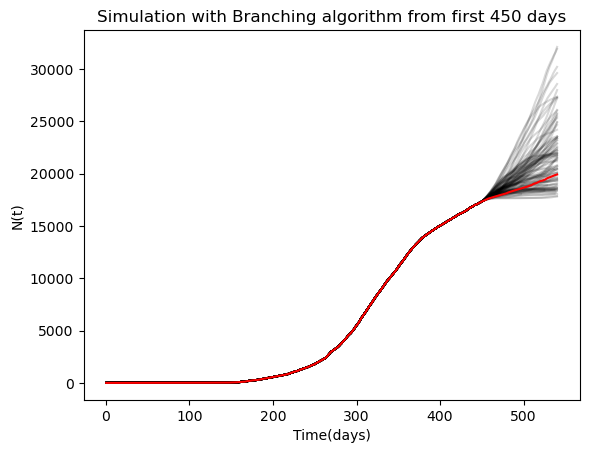

In [19]:
n = binary_search(event_times, 540)
for sample in samples_thinning450:
    plt.plot(sample, range(len(sample)), color="k", alpha=0.15)
plt.plot(event_times[:n], range(n), color='r')
plt.xlabel("Time(days)")
plt.ylabel("N(t)")
plt.title("Simulation with Thinning algorithm from first 450 days")
plt.show()

for sample in samples_branching450:
    plt.plot(sample, range(len(sample)), color="k", alpha=0.15)
plt.plot(event_times[:n], range(n), color='r')
plt.xlabel("Time(days)")
plt.ylabel("N(t)")
plt.title("Simulation with Branching algorithm from first 450 days")
plt.show()